In [7]:
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt

from models.perceptrons.perceptron_non_linear import PerceptronNonLinear
from models.perceptrons.perceptron_linear import PerceptronLinear
# Cargar datos
data = pd.read_csv('../res/TP3-ej2-conjunto.csv')
X = data[['x1', 'x2', 'x3']].values
y = data['y'].values

# Escalar los datos
scaler_tanh = MinMaxScaler(feature_range=(-1, 1))  # Tanh models use -1 to 1 range
X_scaled_tanh = scaler_tanh.fit_transform(X)

scaler_sigmoid = MinMaxScaler(feature_range=(0, 1))  # Sigmoid models use 0 to 1 range
X_scaled_sigmoid = scaler_sigmoid.fit_transform(X)

# No scaling for ReLU
scaler_relu = MinMaxScaler(feature_range=(0, 1))  # ReLU models use 0 to 1 range
X_scaled_relu = scaler_relu.fit_transform(X)



# No need to scale the target for metrics calculation
y_scaled_tanh = scaler_tanh.fit_transform(y.reshape(-1, 1)).ravel()
y_scaled_sigmoid = scaler_sigmoid.fit_transform(y.reshape(-1, 1)).ravel()
y_scaled_relu = scaler_relu.fit_transform(y.reshape(-1, 1)).ravel()
# Configuración de la validación cruzada

seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
results = []
epochs = 100
learning_rate = 0.01
print(kf.split(X))

non_linear_perceptron_params = [
    {'seed': seed, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 0.1, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 0.5, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 1, 'num_epochs':epochs},
    {'seed': seed, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 2.0, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 5.0, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 10.0, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 0.1, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 0.5, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 1.0, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 2.0, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 5.0, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 10.0, 'num_epochs': epochs},
    {'seed': seed, 'num_features': X_scaled_relu.shape[1], 'learning_rate': learning_rate, 'epsilon': 1e-5, 'non_linear_fn': 'relu', 'num_epochs': epochs}
]

epsilon = 1e-10  # Small constant to avoid division by zero

# Loop over the perceptron configurations
for params in non_linear_perceptron_params:
    for train_index, test_index in kf.split(X):
        if params['non_linear_fn'] == 'tanh':
            X_train, X_test = X_scaled_tanh[train_index], X_scaled_tanh[test_index]
            y_train, y_test = y_scaled_tanh[train_index], y_scaled_tanh[test_index]
        elif params['non_linear_fn'] == 'sigmoid':
            X_train, X_test = X_scaled_sigmoid[train_index], X_scaled_sigmoid[test_index]
            y_train, y_test = y_scaled_sigmoid[train_index], y_scaled_sigmoid[test_index]
        else:  # ReLU
            X_train, X_test = X_scaled_relu[train_index], X_scaled_relu[test_index]
            y_train, y_test = y_scaled_relu[train_index], y_scaled_relu[test_index]  # No scaling for y in ReLU

        # Initialize and train perceptron
        perceptron = PerceptronNonLinear(
            seed=params['seed'],
            num_features=params['num_features'],
            learning_rate=params['learning_rate'],
            epsilon=params['epsilon'],
            non_linear_fn=params['non_linear_fn'],
            beta=params.get('beta', 1)  # Beta is optional for some models like relu
        )

        train_losses = []
        test_losses = []
        
        # Modify training loop to store losses
        for epoch in range(epochs):
            perceptron.train(X_train, y_train, epoch)  # Assuming your model has train_epoch()
            
            # After each epoch, calculate the loss on train and test sets
            y_train_pred = perceptron.predict(X_train)
            y_test_pred = perceptron.predict(X_test)

            train_loss = mean_squared_error(y_train, y_train_pred)
            test_loss = mean_squared_error(y_test, y_test_pred)
            
            # Store the losses
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        results.append({
            'model': f"{params['non_linear_fn'].capitalize()}-Beta-{params.get('beta', 'N/A')}",
            'mse': test_loss,
            'mae': mean_absolute_error(y_test, y_test_pred),
            'r2': r2_score(y_test, y_test_pred),
            'rmse': np.sqrt(test_loss),
            'mape': np.mean(np.abs((y_test - y_test_pred) / (y_test + epsilon))) * 100,
            'med_ae': median_absolute_error(y_test, y_test_pred),
            'train_losses': train_losses,  # Store train losses for each epoch
            'test_losses': test_losses    # Store test losses for each epoch
        })


<generator object _BaseKFold.split at 0x756eba0528a0>
Perceptron did not converge in 0 epochs
Perceptron did not converge in 1 epochs
Perceptron did not converge in 2 epochs
Perceptron did not converge in 3 epochs
Perceptron did not converge in 4 epochs
Perceptron did not converge in 5 epochs
Perceptron did not converge in 6 epochs
Perceptron did not converge in 7 epochs
Perceptron did not converge in 8 epochs
Perceptron did not converge in 9 epochs
Perceptron did not converge in 10 epochs
Perceptron did not converge in 11 epochs
Perceptron did not converge in 12 epochs
Perceptron did not converge in 13 epochs
Perceptron did not converge in 14 epochs
Perceptron did not converge in 15 epochs
Perceptron did not converge in 16 epochs
Perceptron did not converge in 17 epochs
Perceptron did not converge in 18 epochs
Perceptron did not converge in 19 epochs
Perceptron did not converge in 20 epochs
Perceptron did not converge in 21 epochs
Perceptron did not converge in 22 epochs
Perceptron di

In [3]:

# Find the best model based on test MSE
best_model_result_mse = min(results, key=lambda x: x['mse'])
best_model_result_mae = min(results, key=lambda x: x['mae'])
best_model_result_r2 = max(results, key=lambda x: x['r2'])
worst_model_result_mse = max(results, key=lambda x: x['mse'])
worst_model_result_mae = max(results, key=lambda x: x['mae'])
worst_model_result_r2 = min(results, key=lambda x: x['r2'])

# Access the training and testing losses for the best model
best_train_losses_mse = best_model_result_mse['train_losses']
best_test_losses_mse = best_model_result_mse['test_losses']

best_train_losses_mae = best_model_result_mae['train_losses']
best_test_losses_mae = best_model_result_mae['test_losses']

best_train_losses_r2 = best_model_result_r2['train_losses']
best_test_losses_r2 = best_model_result_r2['test_losses']

worst_train_losses_mse = worst_model_result_mse['train_losses']
worst_test_losses_mse = worst_model_result_mse['test_losses']

worst_train_losses_mae = worst_model_result_mae['train_losses']
worst_test_losses_mae = worst_model_result_mae['test_losses']

worst_train_losses_r2 = worst_model_result_r2['train_losses']
worst_test_losses_r2 = worst_model_result_r2['test_losses']



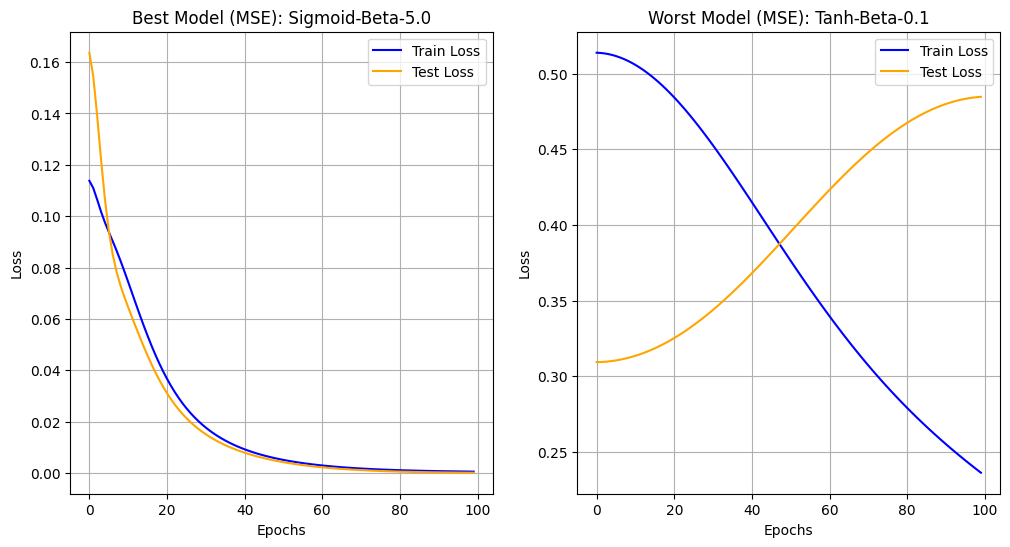

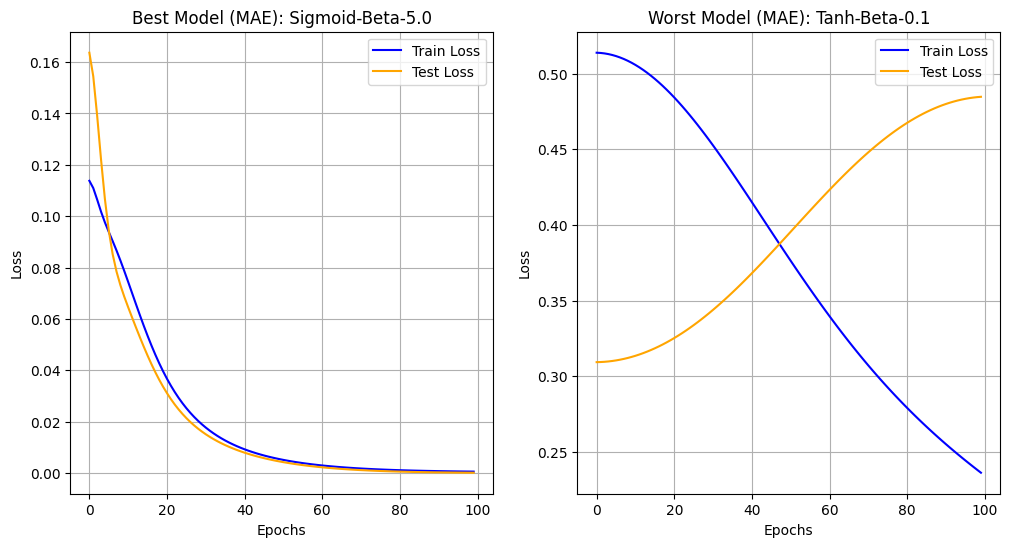

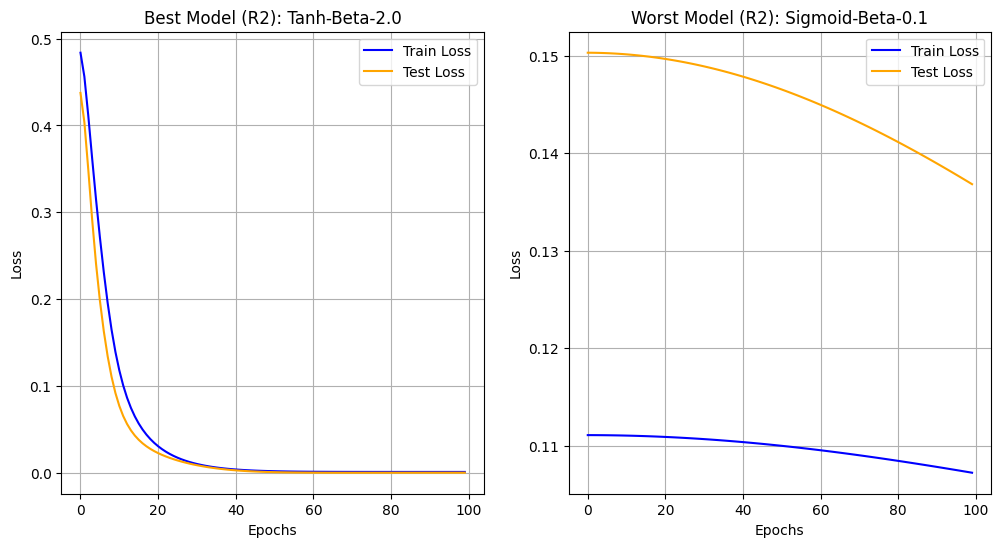

In [6]:
# Plot train vs test losses over epochs for the best model
epochs_range = range(epochs)

def plot_losses(best_model_result, worst_model_result, best_train_losses, best_test_losses,worst_train_losses, worst_test_losses,  metric):
    plt.figure(figsize=(12, 6))
    
    # Best model graph
    plt.subplot(1, 2, 1)  # Create a subplot for best model
    plt.plot(epochs_range, best_train_losses, label='Train Loss', color='blue')
    plt.plot(epochs_range, best_test_losses, label='Test Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel(f'Loss')
    plt.title(f"Best Model ({metric}): {best_model_result['model']}")
    plt.legend()
    plt.grid(True)

    # Worst model graph
    plt.subplot(1, 2, 2)  # Create a subplot for worst model
    plt.plot(epochs_range, worst_train_losses, label='Train Loss', color='blue')
    plt.plot(epochs_range, worst_test_losses, label='Test Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Worst Model ({metric}): {worst_model_result['model']}")
    plt.legend()
    plt.grid(True)

plot_losses(
    best_model_result_mse,
    worst_model_result_mse,
    best_train_losses_mse, 
    best_test_losses_mse, 
    worst_train_losses_mse, 
    worst_test_losses_mse, 
    'MSE')
plot_losses(
    best_model_result_mae,
    worst_model_result_mae,
    best_train_losses_mae,
    best_test_losses_mae,
    worst_train_losses_mae, 
    worst_test_losses_mae, 
    'MAE')
plot_losses(
    best_model_result_r2,
    worst_model_result_r2,  
    best_train_losses_r2, 
    best_test_losses_r2,
    worst_train_losses_r2, 
    worst_test_losses_r2, 
    'R2')



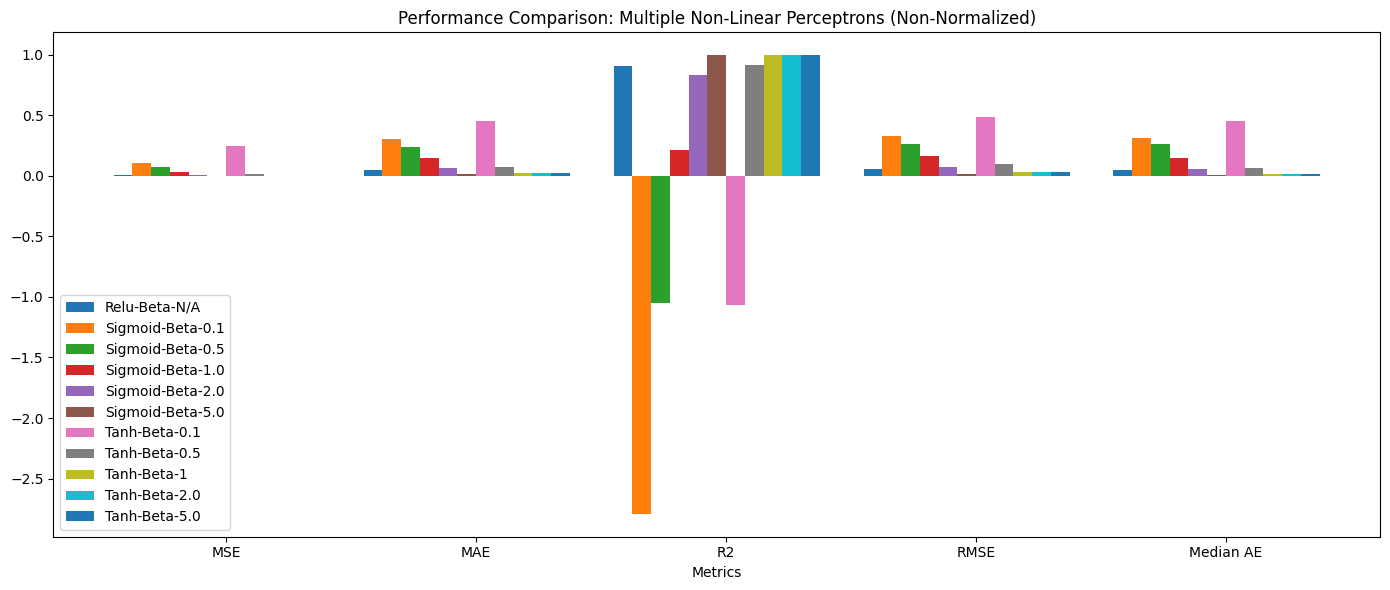

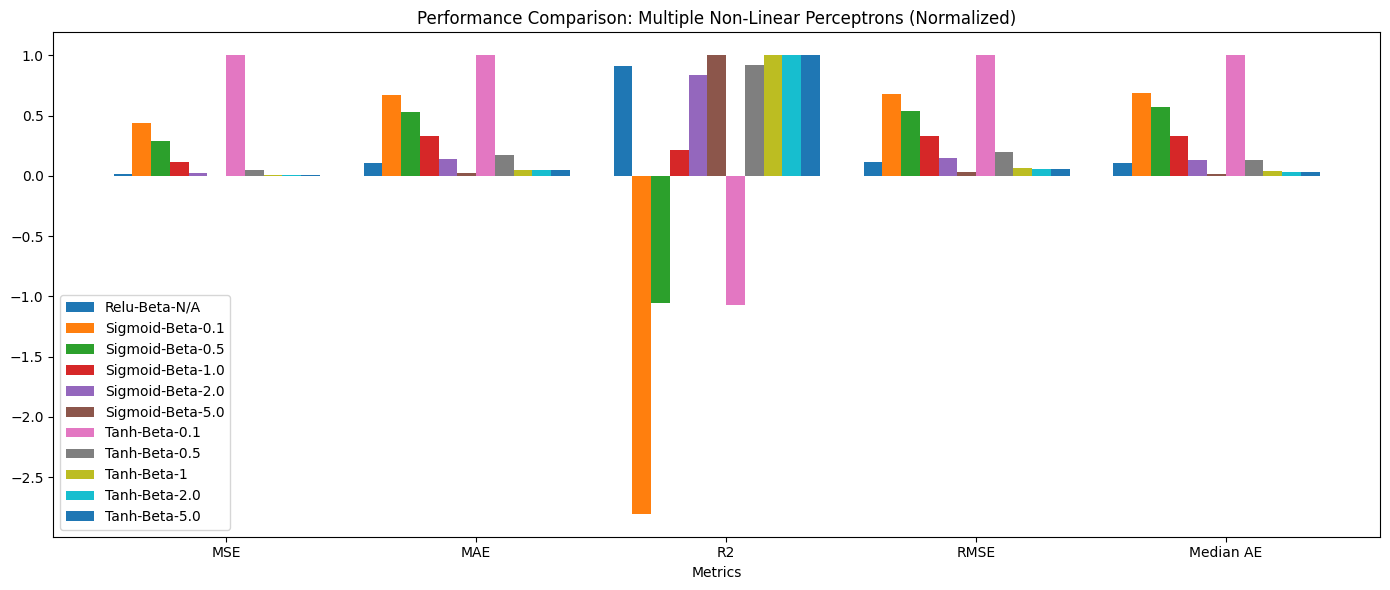

In [17]:
# Update metrics list to remove 'MAPE'
metrics = ['MSE', 'MAE', 'R2', 'RMSE', 'Median AE']  # Removed MAPE
key_map = {'MSE': 'mse', 'MAE': 'mae', 'R2': 'r2', 'RMSE': 'rmse', 'Median AE': 'med_ae'}

# Function to extract the beta value for sorting
def extract_beta(model_name):
    # Extract beta from model name (assumes format "Activation-Beta-X")
    try:
        beta_str = model_name.split('-Beta-')[-1]
        return float(beta_str) if beta_str != 'N/A' else float('inf')  # N/A becomes "infinity" for ReLU
    except ValueError:
        return float('inf')  # Handle any unexpected cases with a fallback

# Sort model names first by function, then by beta value
model_names_sorted = sorted(model_names, key=lambda x: (x.split('-')[0], extract_beta(x)))

# Calculate average metrics for each model, excluding ReLU models
average_metrics = {model: {key_map[metric]: np.mean([res[key_map[metric]] for res in results if res['model'] == model]) for metric in metrics} for model in model_names_sorted}

# Increase space between bars by adding a larger offset
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(metrics)) * 2  # Increasing the space between the label locations
width = 0.15  # The width of the bars

# Add all models to the graph
for i, model in enumerate(model_names_sorted):
    values = [average_metrics[model][key_map[metric]] for metric in metrics]
    ax.bar(x + i * width, values, width, label=model)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Performance Comparison: Multiple Non-Linear Perceptrons (Non-Normalized)')
ax.set_xticks(x + width * (len(model_names_sorted) / 2))
ax.set_xticklabels(metrics)
ax.legend()

# Display the non-normalized graph
plt.tight_layout()
plt.show()

# Now normalize the metrics for a second graph
max_values = {metric: max([average_metrics[model][key_map[metric]] for model in model_names_sorted]) for metric in metrics}
normalized_metrics = {model: {key_map[metric]: average_metrics[model][key_map[metric]] / max_values[metric] for metric in metrics} for model in model_names_sorted}

# Increase space between bars for normalized graph
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(metrics)) * 2  # Again increasing the space between metrics

for i, model in enumerate(model_names_sorted):
    normalized_values = [normalized_metrics[model][key_map[metric]] for metric in metrics]
    ax.bar(x + i * width, normalized_values, width, label=model)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Performance Comparison: Multiple Non-Linear Perceptrons (Normalized)')
ax.set_xticks(x + width * (len(model_names_sorted) / 2))
ax.set_xticklabels(metrics)
ax.legend()

# Display the normalized graph
plt.tight_layout()
plt.show()

